# Building a Prostrate Cancer Prediction Model

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('prostate-cancer-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   lcp      97 non-null     float64
 5   gleason  97 non-null     int64  
 6   pgg45    97 non-null     int64  
 7   lpsa     97 non-null     float64
 8   Target   97 non-null     int64  
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


In [3]:
df['Target'].value_counts()

Target
0    76
1    21
Name: count, dtype: int64

In [4]:
df.isnull().sum()

lcavol     0
lweight    0
age        0
lbph       0
lcp        0
gleason    0
pgg45      0
lpsa       0
Target     0
dtype: int64

In [5]:
df.head()

,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,Target
0,-0.579818,2.769459,50,-1.386294,-1.386294,6,0,-0.430783,0
1,-0.994252,3.319626,58,-1.386294,-1.386294,6,0,-0.162519,0
2,-0.510826,2.691243,74,-1.386294,-1.386294,7,20,-0.162519,0
3,-1.203973,3.282789,58,-1.386294,-1.386294,6,0,-0.162519,0
4,0.751416,3.432373,62,-1.386294,-1.386294,6,0,0.371564,0


In [6]:
df.columns

Index(['lcavol', 'lweight', 'age', 'lbph', 'lcp', 'gleason', 'pgg45', 'lpsa',
       'Target'],
      dtype='object')

# RandomForest Classifier

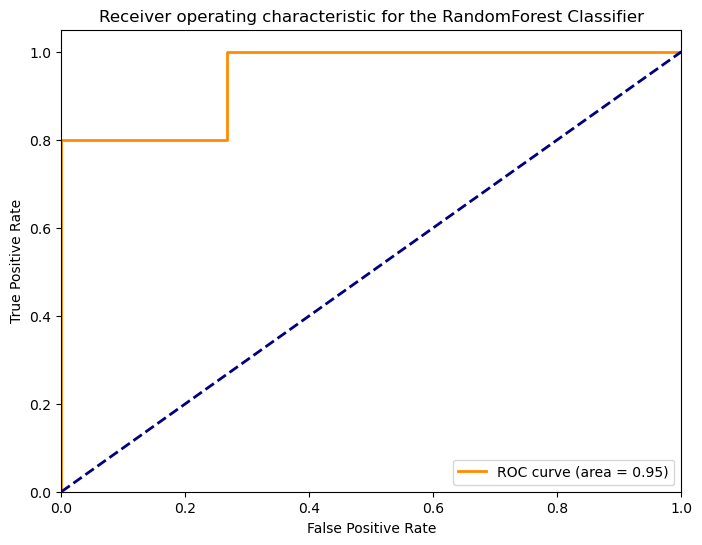

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Split the data into training, validation, and testing sets
X = df.drop('Target', axis=1)
y = df['Target']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Data preprocessing: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Dimensionality reduction: PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_smote)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_smote)

# Get the best hyperparameters and train a new model
best_params = grid_search.best_params_
rf = RandomForestClassifier(**best_params, random_state=42)
rf.fit(X_train_pca, y_train_smote)

# Make predictions on the validation and test sets
y_val_pred = rf.predict(X_val_pca)
y_test_pred = rf.predict(X_test_pca)

# Evaluate the model on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)

# Evaluate the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Compute ROC-AUC curve
y_val_pred_proba = rf.predict_proba(X_val_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for the RandomForest Classifier')
plt.legend(loc="lower right")
plt.show()


**Observation:**

Random Forest ROC Curve:
AUC: 0.95.

The Random Forest classifier shows the best performance among the three models with an AUC of 0.95, indicating that it has excellent classification capability and is very close to perfect discrimination.



In [5]:
print(test_class_report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.50      0.67         4

    accuracy                           0.90        20
   macro avg       0.94      0.75      0.80        20
weighted avg       0.91      0.90      0.89        20



In [6]:
print(test_confusion_matrix)

[[16  0]
 [ 2  2]]


In [13]:
y_train_smote.value_counts()

Target
0    45
1    45
Name: count, dtype: int64

# Xgboost Classifier

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming df is your DataFrame containing the features and the target
# Split the data into training and testing sets
X = df.drop('Target', axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

# Define hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.25, 1.0],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_smote)

# Get the best hyperparameters and train a new model
best_params = grid_search.best_params_
xgb = XGBClassifier(**best_params)
xgb.fit(X_train_pca, y_train_smote)

# Make predictions on the test set
y_pred = xgb.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.50      0.75      0.60         4

    accuracy                           0.80        20
   macro avg       0.71      0.78      0.73        20
weighted avg       0.84      0.80      0.81        20

Confusion Matrix:
[[13  3]
 [ 1  3]]


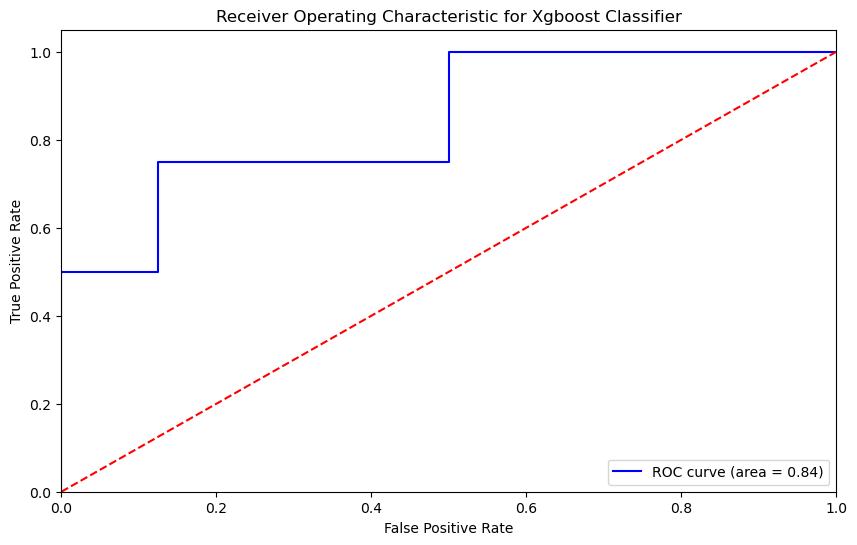

In [16]:
# Compute predicted probabilities for the test set
y_pred_proba = xgb.predict_proba(X_test_pca)[:, 1]


# Plot the ROC curve and calculate the AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Xgboost Classifier')
plt.legend(loc='lower right')
plt.show()

Observation: 

XGBoost ROC Curve:

AUC: 0.84.

This curve shows a stepwise pattern with better performance than the decision tree, and the AUC of 0.84 suggests that the XGBoost model has better classification ability.

# Decision Tree Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the features and the target
# Split the data into training, validation, and testing sets
X = df.drop('Target', axis=1)
y = df['Target']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_smote)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Define hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train_smote)

# Get the best hyperparameters and train a new model
best_params = grid_search.best_params_
dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train_pca, y_train_smote)

# Make predictions on the validation and test sets
y_val_pred = dt.predict(X_val_pca)
y_test_pred = dt.predict(X_test_pca)

# Evaluate the model on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)

# Evaluate the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)


print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_class_report)
print("Test Confusion Matrix:\n", test_confusion_matrix)


Test Accuracy: 0.8
Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.50      0.50      0.50         4

    accuracy                           0.80        20
   macro avg       0.69      0.69      0.69        20
weighted avg       0.80      0.80      0.80        20

Test Confusion Matrix:
 [[14  2]
 [ 2  2]]


In [16]:
best_params

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [17]:
# Make predictions on the validation and test sets
y_val_pred = dt.predict(X_val_pca)
y_test_pred = dt.predict(X_test_pca)


# Evaluate the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.8
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.50      0.50      0.50         4

    accuracy                           0.80        20
   macro avg       0.69      0.69      0.69        20
weighted avg       0.80      0.80      0.80        20

Test Confusion Matrix:
[[14  2]
 [ 2  2]]


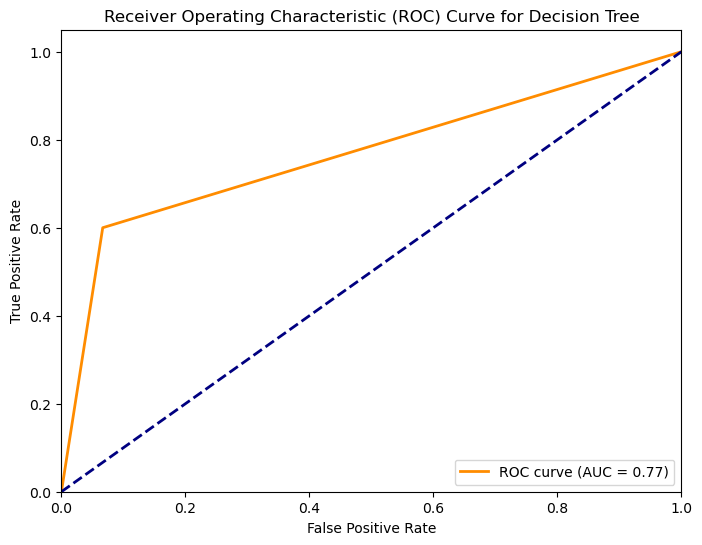

In [18]:
# Plot ROC curve
y_val_pred_proba = dt.predict_proba(X_val_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

Observation:

Decision Tree ROC Curve:

AUC (Area Under the Curve): 0.77.
The ROC curve is above the diagonal (random chance), indicating a reasonably good model. However, an AUC of 0.77 suggests that the decision tree classifier has moderate discrimination ability between classes, but there’s room for improvement.

# Which model is the best to use?

Based on the ROC curves and the AUC values for the three models:

- Decison Tree Classifier: AUC = 0.77
- XGBoost Classifier: AUC = 0.84
- Random Forest Classifier: AUC = 0.95

The Random Forest Classifier is the best model to use, it has the highest AUC score, which means that it has good discriminative power and performance

In [19]:
# saving the model, scaler and pca as a .sav file
import joblib

joblib.dump(scaler, 'scaler.sav')
joblib.dump(pca, 'pca.sav')
joblib.dump(rf, 'rf_model.sav')

NameError: name 'scaler' is not defined

In [20]:
# loading the model, scaler and pca
scaler = joblib.load('scaler.sav')
pca = joblib.load('pca.sav')
rf_model = joblib.load('rf_model.sav')
new_data = [[-0.579818495, 2.769459, 70, -1.38629436, -1.38629436, 6, 0, -0.4307829]]


new_data_scaled = scaler.transform(new_data)



In [21]:
new_data_pca = pca.transform(new_data_scaled)

In [22]:
prediction = rf_model.predict(new_data_pca)

In [23]:
prediction

array([0])

# Building the RNN Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd


# Split the data into training, validation, and testing sets
X = df.drop('Target', axis=1)
y = df['Target']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Data preprocessing: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train_smote)  
y_val_tensor = torch.LongTensor(y_val.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Creating DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
# RNN Model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out

In [23]:
# hyperparameters
input_size = 8
hidden_size = 64
num_layers = 2
num_classes = 2

model = RNNModel(input_size, hidden_size, num_layers, num_classes)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)  
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


In [25]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/100], Train Loss: 4.0701, Val Loss: 1.2845, Val Accuracy: 80.00%
Epoch [2/100], Train Loss: 3.4447, Val Loss: 1.1396, Val Accuracy: 85.00%
Epoch [3/100], Train Loss: 2.9495, Val Loss: 0.9808, Val Accuracy: 90.00%
Epoch [4/100], Train Loss: 2.3942, Val Loss: 0.8415, Val Accuracy: 90.00%
Epoch [5/100], Train Loss: 1.9362, Val Loss: 0.7165, Val Accuracy: 90.00%
Epoch [6/100], Train Loss: 1.5832, Val Loss: 0.6105, Val Accuracy: 95.00%
Epoch [7/100], Train Loss: 1.3812, Val Loss: 0.5420, Val Accuracy: 95.00%
Epoch [8/100], Train Loss: 1.2318, Val Loss: 0.4811, Val Accuracy: 95.00%
Epoch [9/100], Train Loss: 1.1742, Val Loss: 0.4546, Val Accuracy: 95.00%
Epoch [10/100], Train Loss: 1.1654, Val Loss: 0.4166, Val Accuracy: 95.00%
Epoch [11/100], Train Loss: 1.1057, Val Loss: 0.4184, Val Accuracy: 95.00%
Epoch [12/100], Train Loss: 1.0755, Val Loss: 0.4136, Val Accuracy: 95.00%
Epoch [13/100], Train Loss: 1.1783, Val Loss: 0.4520, Val Accuracy: 90.00%
Epoch [14/100], Train Loss: 1.1527

In [26]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add sequence dimension
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.1046, Test Accuracy: 85.00%


In [27]:
import torch

# A New data to predict
new_data = [[-0.579818495, 2.769459, 70, -1.38629436, -1.38629436, 6, 0, -0.4307829]]

# Convert new data to a PyTorch tensor
new_data_tensor = torch.FloatTensor(new_data)

# Normalize the new data using the same scaler
new_data_scaled = scaler.transform(new_data)
new_data_tensor = torch.FloatTensor(new_data_scaled)

# Add a sequence dimension (batch_size=1, sequence_length=1, input_size=8)
new_data_tensor = new_data_tensor.unsqueeze(0)

# make sure that the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    output = model(new_data_tensor)
    _, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class: {predicted_class.item()}')


Predicted class: 0


In [28]:
torch.save(model, 'rnn_model.pth')

In [29]:
import torch
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler


# Load the trained RNN model
model = torch.load('rnn_model.pth')

# Set the model to evaluation mode
model.eval()

# New data for prediction
new_data = [[-0.579818495, 2.769459, 70, -1.38629436, -1.38629436, 6, 0, -0.4307829]]

# Load the scaler (assuming it was saved using joblib or similar)
scaler = StandardScaler()

scaler = joblib.load('scaler.sav')  

# Scale the new data
new_data_scaled = scaler.transform(new_data)

# Convert the new data to a PyTorch tensor and add the sequence dimension
new_data_tensor = torch.FloatTensor(new_data_scaled).unsqueeze(0)

# Make prediction
with torch.no_grad():
    output = model(new_data_tensor)
    _, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class: {predicted_class.item()}')


Predicted class: 0
